# Тестовое задание на позицию - Аналитик данных (направление BI)
исп.: Ю.В. Сулковская

Задание: Представлена штатная численность предприятия, которое имеет офисы по всей России. Период наблюдения - 5 месяцев.\
Сотрудник, отвечающий за подготовку отчетности на предприятии, при анализе таблицы столкнулся с некоторыми проблемами, которые мешают подготовить отчет руководству.\
Помогите ему, изучите данные и решите поставленные задачи.

In [1]:
import pandas as pd # v.1.5.3
import plotly.express as px # v.5.9.0
import datetime as dt

In [2]:
#изменяет формат графиков на png, для возможности отображения в GitHub.
#*необходим только для публикации. В рамках анализа лучше не использовать, для возможности просмотра точных цифр на графиках.
import plotly.io as pio
pio.renderers.default = 'png' 

Считаем данные по городам:

In [3]:
cities = pd.read_excel('C:/Users/Julia/HEXProjects/datasets/HR_analisys/Города.xlsx')

In [4]:
cities.head()

,Федеральный округ,Регион,Город
0,ДФО,Амурская обл.,Белогорск
1,ДФО,Амурская обл.,Благовещенск
2,ДФО,Амурская обл.,Завитинск
3,ДФО,Амурская обл.,Магдагачи
4,ДФО,Амурская обл.,Свободный


Таблица Города:
- Федеральный округ - Текст (пропуски не допускаются)
- Регион - Текст (пропуски не допускаются)
- Город - Текст (уникальный)


In [5]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Федеральный округ  493 non-null    object
 1   Регион             493 non-null    object
 2   Город              493 non-null    object
dtypes: object(3)
memory usage: 11.7+ KB


In [6]:
cities['Город'].nunique()

490

с помощью метода nunique() были обнаружены дубликаты, которые можны убрать методом drop_duplicates() по полям Город и Регион. В данном случае это не принесет никаких результатов, так как городам с одинаковыми названиями могут находиться в разных регионах. Найдем их с помощью метода .duplicates:

In [7]:
cities['Дубль'] = cities.duplicated(subset=['Город'])

In [8]:
dupes = cities.query('Дубль == True')['Город']

In [9]:
cities.query('Город in @dupes')

,Федеральный округ,Регион,Город,Дубль
4,ДФО,Амурская обл.,Свободный,False
253,СФО,Красноярский край,Железногорск,False
294,УФО,Свердловская обл.,Свободный,True
327,УФО,Челябинская обл.,Троицк,False
359,ЦФО,г. Москва,Троицк,True
372,ЦФО,Курская обл.,Железногорск,True


При проверке мы видим, что города действительно могут иметь одинаковые наименования, но при этом находятся в разных регионах. В таких случаях необходимо рассматрировать данные только по двум полям, во избежание ошибок, либо всё же отсеять часть дубликатов.

In [10]:
cities = cities.drop_duplicates(subset=['Город'])

In [11]:
cities.shape

(490, 4)

Считаем данные по сотрудникам:

In [12]:
employees = pd.read_excel('C:/Users/Julia/HEXProjects/datasets/HR_analisys/ШЧ.xlsx')

In [13]:
employees.head()

,Период,ID должности,Табельный номер,Город,Должность,ФИО
0,2023-01-01,1000,2201.0,Новоуральск,главный клиентский менеджер розничного бизнеса,Корнеев З.
1,2023-01-01,1001,2202.0,Оленегорск,управляющий операционным офисом,Сергеев Е.
2,2023-01-01,1002,2203.0,Североуральск,руководитель группы,Корнеев Д.
3,2023-01-01,1003,2204.0,Жуковка,офис-менеджер,Петров Н.
4,2023-01-01,1004,2205.0,Воркута,эксперт по работе с партнерами,Корнеев Я.


Таблица ШЧ:
- Период - формат Дата (пропуски не допускаются)
- ID должности - целое число (пропуски не допускаются, уникальный на каждый период)
- Табельный номер - целое число (допускаются пропуски)
- Город - Текст (допускаются пропуски)
- Должность - Текст (допускаются пропуски)
- ФИО - Текст (допускаются пропуски)


In [14]:
employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4995 entries, 0 to 4994
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Период           4995 non-null   datetime64[ns]
 1   ID должности     4995 non-null   object        
 2   Табельный номер  4883 non-null   float64       
 3   Город            4880 non-null   object        
 4   Должность        4856 non-null   object        
 5   ФИО              4883 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 234.3+ KB


# 1. Предобработка данных

1.1 Рассмотрим ошибки, встречающиеся в датасетах:
- Очевидная серийная дата экселя в виде "44927", которую необходимо перевести в DateTime. Параметр converters= {'Период': pd.to_datetime} работает не совсем корректно, поэтому для конвертации можно использовать стороннюю функцию.

In [15]:
employees['Период'] = employees['Период'].astype(str)

In [16]:
#Используем функцию для конвертации серийной даты в DateTime

def excel_date(x):
    res = pd.to_datetime(x, errors='coerce')
    temp = res.isna()
    res.loc[temp] = pd.to_timedelta(x[temp].astype('float'), unit='d') + dt.datetime(1899, 12, 30)
    return res

In [17]:
employees['Период'] = excel_date(employees['Период'])

- Распространенными способами обнаружить битые данные, можно через методы dtypes, isna() или через unique();
- В столбце ['ID должности'] с помощью методов dtypes и unique() выявлены данные в виде '1808,Шушары'. Лишние символы можно отрезать с помощью метода split():

In [18]:
employees['ID должности'].unique()

array([1000, 1001, 1002, ..., 1998, 1013, '1808,Шушары'], dtype=object)

In [19]:
employees['ID должности'] = employees['ID должности'].astype(str)
employees['ID должности'] = employees.apply(lambda x:x['ID должности'].split(',')[0], axis=1)
employees['ID должности'] = employees['ID должности'].astype(int)

In [20]:
employees['Должность'].isna().sum()

139

In [21]:
employees['Город'].isna().sum()

115

In [22]:
employees['ФИО'].isna().sum()

112

In [23]:
employees['Табельный номер'].isna().sum()

112

1.2 Восстановим утерянные данные:
- Из вышеуказанного я могу предположить, что количество пропусков в ФИО и Табельном номере являются корректными, тк должности могут быть вакантны;
- От остальных пропусков можно избавиться, если заново переджоинить таблицу по Табельному номеру (для пропавших данных действующих сотрудников) и ID должности (для пропавших данных вакантных позиций), а затем избавиться от возможных дубликатов с помощью метода drop_duplicates (иные дубликаты в датасете не обнаружены):

In [24]:
employees = employees[['Период','ID должности','Табельный номер']].merge(employees[['Табельный номер','Город','Должность','ФИО']], on='Табельный номер',how='left').drop_duplicates(subset=['Период','ID должности','Табельный номер'])

In [25]:
employees = employees.merge(employees[['ID должности','Должность','Город']].dropna().drop_duplicates(keep='first'), on='ID должности',how='left').drop_duplicates(subset=['Период','ID должности','Табельный номер']).drop(['Город_x','Должность_x'],axis=1).rename(columns={'Должность_y':'Должность','Город_y':'Город'})

In [26]:
employees.shape

(4995, 6)

In [27]:
employees['Должность'].isna().sum()

0

In [28]:
employees['Табельный номер'].isna().sum()

112

# 2. Сводные данные по месяцам

- 2.1 Для подсчета действующих сотрудников, необходимо сложить количество Табельных номеров:

In [29]:
employees.groupby(['Период','Должность'],as_index=False)\
    .agg({'Табельный номер':'nunique'})\
    .head(10)

,Период,Должность,Табельный номер
0,2023-01-01,ведущий специалист,45
1,2023-01-01,главный клиентский менеджер розничного бизнеса,30
2,2023-01-01,главный кредитный аналитик,40
3,2023-01-01,главный менеджер,31
4,2023-01-01,главный менеджер по привлечению корпоративных ...,41
5,2023-01-01,главный менеджер счета,30
6,2023-01-01,главный менеджер эквайринга,42
7,2023-01-01,главный персональный менеджер,34
8,2023-01-01,главный специалист,29
9,2023-01-01,директор,48


- 2.2 Для подсчета количества вакантных мест, необходимо проставить логический признак на отсутствующие данные, а затем сложить их:

In [30]:
employees['Вакансия'] = employees['Табельный номер'].isna()

In [31]:
employees.groupby(['Период'],as_index=False)\
    .agg({'Вакансия':'sum'})\
    .query('Вакансия >0')

,Период,Вакансия
0,2023-01-01,13
1,2023-02-01,24
2,2023-03-01,24
3,2023-04-01,29
4,2023-05-01,22


In [32]:
# Более детализованный вариант
employees.groupby(['Период','Должность'],as_index=False)\
    .agg({'Вакансия':'sum'})\
    .query('Вакансия >0').head(10)

,Период,Должность,Вакансия
4,2023-01-01,главный менеджер по привлечению корпоративных ...,1
7,2023-01-01,главный персональный менеджер,1
11,2023-01-01,директор по работе с состоятельными клиентами,1
12,2023-01-01,заместитель управляющего,1
15,2023-01-01,менеджер,1
16,2023-01-01,младший специалист,1
17,2023-01-01,начальник отдела,1
20,2023-01-01,старший кассир,1
22,2023-01-01,управляющий директор,1
23,2023-01-01,управляющий директор - начальник отдела,3


- 2.3 Для подсчета Доля свободных должностей необходимо разделить кол-во Вакансий на кол-во всех должностей:

In [33]:
employees_group = employees.groupby(['Период'],as_index=False)\
    .agg({'Табельный номер':'nunique','Вакансия':'sum'})\
    .sort_values('Вакансия',ascending=False)
employees_group.head()

,Период,Табельный номер,Вакансия
3,2023-04-01,970,29
1,2023-02-01,975,24
2,2023-03-01,975,24
4,2023-05-01,977,22
0,2023-01-01,986,13


In [34]:
employees_group['Доля свободных должностей'] = round(employees_group['Вакансия'] / (employees_group['Вакансия']+employees_group['Табельный номер']) * 100,2)

In [35]:
employees_group.head()

,Период,Табельный номер,Вакансия,Доля свободных должностей
3,2023-04-01,970,29,2.9
1,2023-02-01,975,24,2.4
2,2023-03-01,975,24,2.4
4,2023-05-01,977,22,2.2
0,2023-01-01,986,13,1.3


# 3. Соединение таблиц

- 3.1 Смерджим данные из двух датасетов с помощью left джоина:

In [36]:
employees_complete = employees.merge(cities, on='Город',how='left')

In [37]:
employees_complete.head()

,Период,ID должности,Табельный номер,ФИО,Должность,Город,Вакансия,Федеральный округ,Регион,Дубль
0,2023-01-01,1000,2201.0,Корнеев З.,главный клиентский менеджер розничного бизнеса,Новоуральск,False,УФО,Свердловская обл.,False
1,2023-01-01,1001,2202.0,Сергеев Е.,управляющий операционным офисом,Оленегорск,False,СЗФО,Мурманская обл.,False
2,2023-01-01,1002,2203.0,Корнеев Д.,руководитель группы,Североуральск,False,УФО,Свердловская обл.,False
3,2023-01-01,1003,2204.0,Петров Н.,офис-менеджер,Жуковка,False,ЦФО,Московская обл.,False
4,2023-01-01,1004,2205.0,Корнеев Я.,эксперт по работе с партнерами,Воркута,False,СЗФО,Респ. Коми,False


In [38]:
employees_complete.shape

(4995, 10)

- 3.2 Чтобы найти количество месяцев поиска сотрудника на должность, необходимо отсортировать только строки с открытой Вакансией и сгруппировать должности, сложив месяцы (возможно здесь может быть ошибка, если к примеру, в январе,феврале не было сотрудника, в марте он проработал и уволился, а в апреле снова открыта вакансия):

In [39]:
employees_complete.query('Вакансия == True')\
    .groupby(['ID должности','Должность'],as_index=False)\
    .agg({'Период':'count'}).head(10)

,ID должности,Должность,Период
0,1070,менеджер,4
1,1099,начальник отдела,4
2,1104,младший специалист,4
3,1118,управляющий директор,4
4,1145,управляющий директор - начальник отдела,2
5,1166,главный персональный менеджер,2
6,1184,управляющий директор - начальник отдела,2
7,1209,директор по работе с состоятельными клиентами,2
8,1246,главный менеджер по привлечению корпоративных ...,4
9,1280,заместитель управляющего,4


# 4 Кадровый анализ

- 4.1. Найдем города, в которых больше всего наблюдается нехватка кадров в последний месяц:

In [40]:
employees_complete['Период'].max()

Timestamp('2023-05-01 00:00:00')

In [41]:
employees_complete.query('Период == "2023-05-01" and Вакансия == True')\
    .groupby('Город',as_index=False)\
    .agg({'Должность':'count'})\
    .sort_values('Должность',ascending=False).head(10)

,Город,Должность
2,Биробиджан,2
4,Городец,2
0,Анжеро-Судженск,1
11,Лобня,1
18,Сосновый Бор,1
17,Советский,1
16,Новый Уренгой,1
15,Нововоронеж,1
14,Нижний Новгород,1
13,Миасс,1


- 4.2. Найдем регионы, в которых больше всего работает сотрудников в последний месяц:

In [42]:
employees_complete.query('Период == "2023-05-01" and Вакансия == False')\
    .groupby('Регион',as_index=False)\
    .agg({'Должность':'count'})\
    .sort_values('Должность',ascending=False).head(10)

,Регион,Должность
24,Московская обл.,56
54,Свердловская обл.,50
60,Ханты-Мансийский Автономный округ - Югра,36
27,Нижегородская обл.,34
25,Мурманская обл.,33
52,Саратовская обл.,30
21,Ленинградская обл.,30
15,Кемеровская область - Кузбасс,29
47,Респ. Татарстан,28
11,Иркутская обл.,28


- 4.3 Выведем должности, которые подвержены наибольшей текучести по коэффициенту:

In [43]:
employees_group2 = employees.groupby(['Должность','Период'],as_index=False)\
    .agg({'Табельный номер':'nunique','Вакансия':'sum'})\
    .sort_values('Вакансия',ascending=False)
employees_group2.head()

,Должность,Период,Табельный номер,Вакансия
123,управляющий операционным офисом,2023-04-01,35,4
12,главный кредитный аналитик,2023-03-01,37,3
116,управляющий директор - начальник отдела,2023-02-01,43,3
124,управляющий операционным офисом,2023-05-01,36,3
14,главный кредитный аналитик,2023-05-01,37,3


In [44]:
employees_group2['Доля свободных должностей'] = round(employees_group2['Вакансия'] / (employees_group2['Вакансия']+employees_group2['Табельный номер']) * 100,2)

In [45]:
employees_group2.head(10)

,Должность,Период,Табельный номер,Вакансия,Доля свободных должностей
123,управляющий операционным офисом,2023-04-01,35,4,10.26
12,главный кредитный аналитик,2023-03-01,37,3,7.50
116,управляющий директор - начальник отдела,2023-02-01,43,3,6.52
124,управляющий операционным офисом,2023-05-01,36,3,7.69
14,главный кредитный аналитик,2023-05-01,37,3,7.50
13,главный кредитный аналитик,2023-04-01,37,3,7.50
115,управляющий директор - начальник отдела,2023-01-01,43,3,6.52
98,руководитель группы,2023-04-01,34,2,5.56
97,руководитель группы,2023-03-01,34,2,5.56
96,руководитель группы,2023-02-01,34,2,5.56


# 5. Визуализация

Для более интерактивных графиков, можно использовать библиотеку plotly.express.
- 5.1 Количество действующих сотрудников по Федеральным округам:

In [46]:
workers = employees_complete.query('Период == "2023-05-01" & Вакансия == False')\
    .groupby('Федеральный округ',as_index=False)\
    .agg({'Табельный номер':'nunique'})\
    .rename(columns={'Табельный номер':'Количество сотрудников'})\
    .sort_values('Количество сотрудников',ascending=False).head(10)

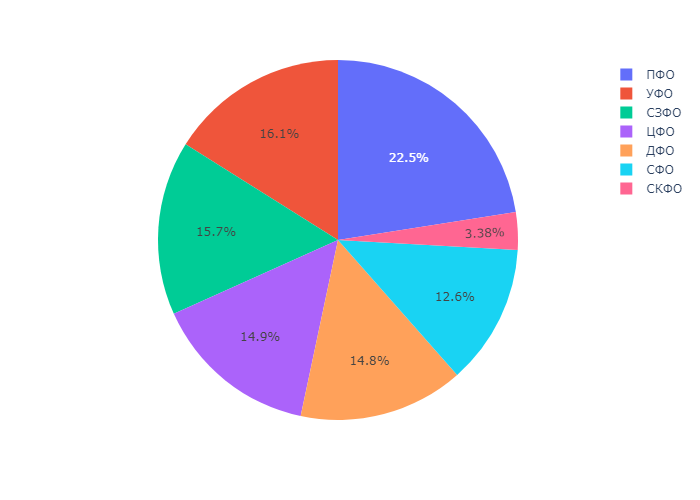

In [47]:
df = px.data.tips()
fig = px.pie(workers, values='Количество сотрудников', names='Федеральный округ')
fig.show()

Из данных вышеуказанного графика установлено, что, преимущественно, самым занятым округом (по самым актуальным данным) является Приволжский федеральный округ - 220 работающих сотрудников.

- 5.2. Количество свободных должностей по регионам:

In [48]:
vacancion = employees_complete.query('Период == "2023-05-01" & Вакансия == True')\
    .groupby(['Регион'],as_index=False)\
    .agg({'ID должности':'nunique','Должность':'unique'})\
    .rename(columns={'ID должности':'Количество вакансий'})\
    .sort_values('Количество вакансий',ascending=False).head(10)

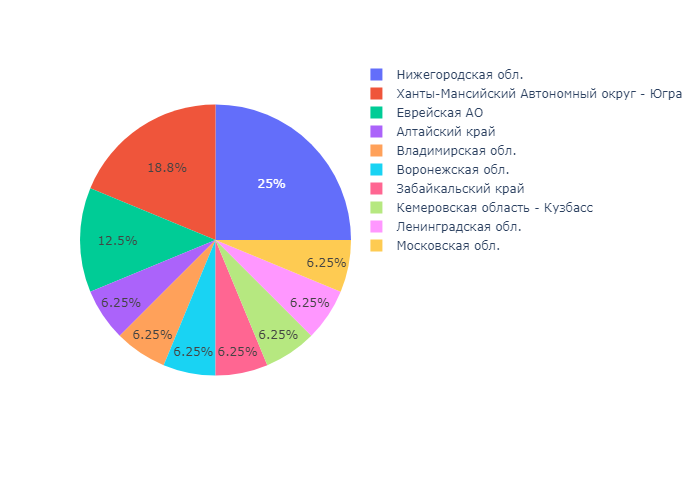

In [49]:
df = px.data.tips()
fig = px.pie(vacancion, values='Количество вакансий', names='Регион',hover_data=['Должность'])
fig.show()

Из данных вышеуказанного графика установлено, что, преимущественно, самым вакантным регионом (по самым актуальным данным) является Нижегородская область - 4 свободных должности, а именно Директор, глав.кредитный аналитик, старший кассир и зам.управляющего операционным офисом.